In [3]:
import pandas as pd
import os
import plot_constants as pltconst
import matplotlib.pyplot as plt
from datetime import datetime

from plot_constants import uzh_colors

In [4]:
pltconst.set_plot_parameters()

In [11]:
nft_dir = "/mnt/Ivana/Data/Tezos/DataDuringProcessing/NFT/"
transfers_dir = nft_dir + "Transfers/"
temp_dir = nft_dir + "Temp/"
accounts_dir = nft_dir + "Accounts/"


### Merge token transfer details

In [6]:
def merge_all_csv_files_from_folder_add_token_details(folder_path):
    all_dfs = []
    
    for file_name in os.listdir(folder_path):
        token_contract, tokenId = file_name.replace(".csv", "").split("_")
        df = pd.read_csv(folder_path + file_name)
        df["tokenId"] = tokenId
        df["contract_address"] = token_contract
        df["unique_token_id"] = file_name.replace(".csv", "")
        all_dfs.append(df)
    
    result = pd.concat(all_dfs, axis=0)
    return result

In [99]:
# Create merged files with all token transfers per account
subdirectories = [f for f in os.listdir(temp_dir) if os.path.isdir(os.path.join(temp_dir, f))]

for folder in subdirectories:
    file_name = transfers_dir + folder + "_all_transfers.csv"
    df = merge_all_csv_files_from_folder_add_token_details(temp_dir + folder + "/")
    df.to_csv(file_name, index=False)

### Create aggregated price statistics for combined collections

In [7]:
def convert_to_transfer_list(df_org):
    df = df_org.copy()
    df.price = pd.to_numeric(df.price) / 10**6
    df = df[df.price > 0]
    df = df[["timestamp", "price", "fromAddress", "toAddress", "unique_token_id"]]
    df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%dT%H:%M:%SZ")
    df["Date"] = df.timestamp.apply(lambda x: x.date())
    return df

In [40]:
def aggregate_df(df, name="coll", frequency="Date"):
    agg_cols = ["sum", "count", "mean"]
    if frequency == "Date":
        aggregations = df.groupby("Date").agg({"price":["sum", "count", "mean"]}).reset_index()  
    else:
        aggregations = df.set_index("Date").resample("W").agg({"price":["sum", "count", "mean"]}).reset_index()

    
    aggregations.columns = ["Date"] + [name + "_" + c for c in agg_cols]
    
    return aggregations

In [9]:
def create_aggregation_df(transfers_dir, frequency = "Date"):
    results = None

    for file in os.listdir(transfers_dir):
        name = file.replace("_all_transfers.csv", "")
        df = pd.read_csv(transfers_dir + file)
        
        # Extract only transfers with price higher than 0
        only_transfers_with_price = convert_to_transfer_list(df)
        only_transfers_with_price.Date = pd.to_datetime(only_transfers_with_price.Date)

        # Create aggregations based on given frequency for the price column
        aggregations = aggregate_df(only_transfers_with_price, name, frequency)
        if results is None:
            results = aggregations
        else:
            results = pd.merge(results, aggregations, how = "outer", on = "Date")

    results.fillna(0, inplace=True)
    return results

In [161]:
results = create_aggregation_df(transfers_dir=transfers_dir, frequency="Date")
results_week = create_aggregation_df(transfers_dir=transfers_dir, frequency="Week")

/tmp/ipykernel_3795554/1930093466.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(transfers_dir + file)
/tmp/ipykernel_3795554/1930093466.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(transfers_dir + file)


In [162]:
mean_cols = [c for c in results.columns if "_mean" in c]
sum_cols = [c for c in results.columns if "_sum" in c]
count_cols = [c for c in results.columns if "_count" in c]

results["total_sum"] = results.apply(lambda x: sum(x[sum_cols]), axis = 1)
results["total_count"] = results.apply(lambda x: sum(x[count_cols]), axis = 1)
results["total_mean"] = results.apply(lambda x: x["total_sum"]/x["total_count"], axis = 1)

<AxesSubplot: xlabel='Date'>

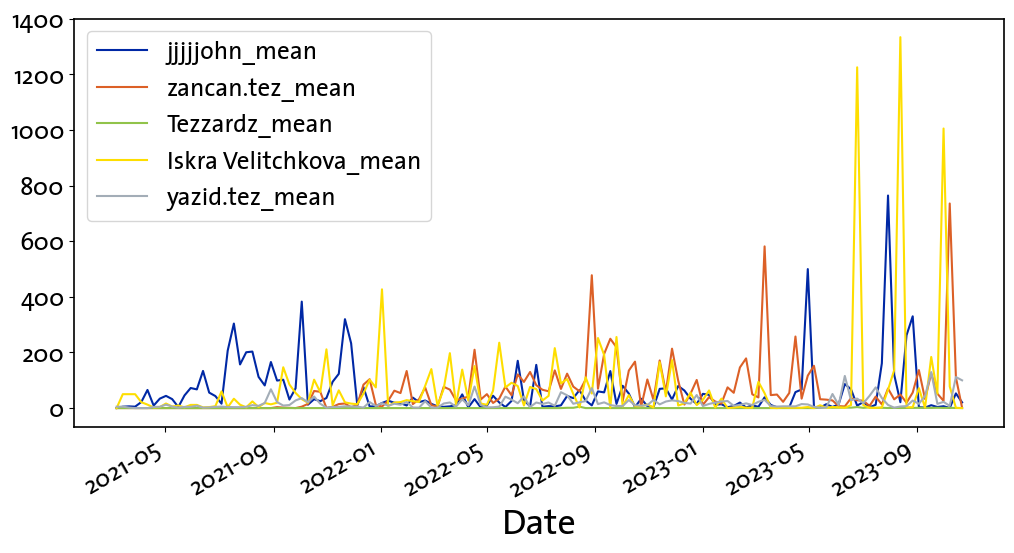

In [164]:
results_week.plot(x="Date", y = mean_cols, figsize=(12, 6))

<AxesSubplot: xlabel='Date', ylabel='Price'>

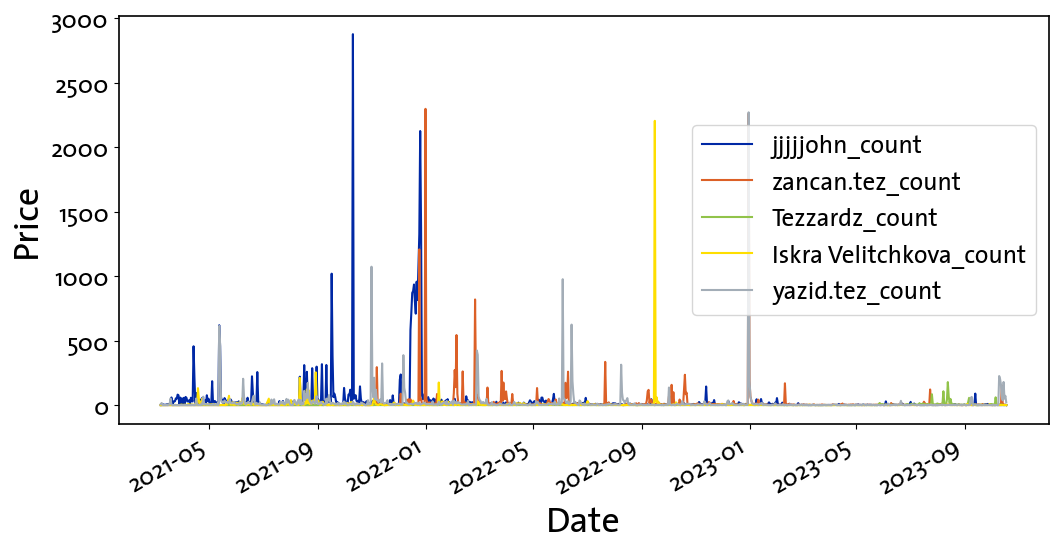

In [165]:
results.plot(x="Date", y = count_cols, figsize=(12, 6), ylabel="Price")

### Get NFTs with most transfers from each creator

In [212]:
NFTs = {}

for file in os.listdir(transfers_dir):
    name = file.replace("_all_transfers.csv", "")

    account_df = pd.read_csv(accounts_dir + name +".csv")
    account_df.tokenId = account_df.tokenId.apply(str)
    df = pd.read_csv(transfers_dir + file)
    
    # Extract only transfers with price higher than 0
    only_transfers_with_price = convert_to_transfer_list(df)
    tx_counts = only_transfers_with_price.groupby("unique_token_id").price.count().sort_values(ascending=False).reset_index(name="counts")
    tgt_NFT = tx_counts.loc[tx_counts.counts == max(tx_counts.counts), "unique_token_id"].values[0]

    contract_address, token_id = tgt_NFT.split("_")
    NFT_name = account_df.loc[(account_df.contract_address == contract_address) & (account_df.tokenId == token_id), "name"].values[0]
    print(name, NFT_name)

    tgt_transfers = only_transfers_with_price[only_transfers_with_price.unique_token_id == tgt_NFT]
    tgt_transfers = tgt_transfers[["Date", "price"]]
    tgt_transfers.Date = pd.to_datetime(tgt_transfers.Date)

    NFTs[NFT_name] = tgt_transfers


/tmp/ipykernel_3795554/2974332792.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(transfers_dir + file)


jjjjjohn Window Still Life 084
zancan.tez Lushtemples — Heart Shaped
Tezzardz Strange Creatures 02
Iskra Velitchkova Lost control
yazid.tez Synchronicity


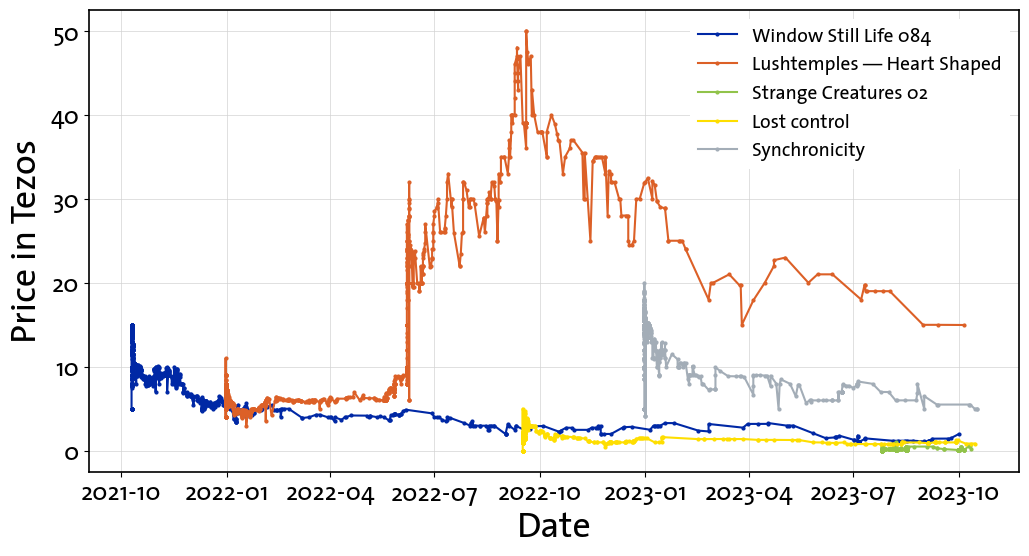

In [213]:
plt.figure(figsize=(12, 6))

for key, value in NFTs.items():
    plt.plot(value.Date, value.price, marker='o', markersize=2, label=key)
    
plt.grid(zorder=100, lw =0.5, color = 'lightgray')
leg = plt.legend(frameon=True,facecolor='white', framealpha=1, fontsize = 14)
frame = leg.get_frame()
frame.set_linewidth(0)

plt.xlabel("Date")
plt.ylabel("Price in Tezos")
plt.show()


### Create data sets with model information for target NFTs

In [41]:
target_tokens_dir = nft_dir + "Target_tokens/"

for file in os.listdir(transfers_dir):
    name = file.replace("_all_transfers.csv", "")
    df = pd.read_csv(transfers_dir + file)
    
    # Extract only transfers with price higher than 0
    only_transfers_with_price = convert_to_transfer_list(df)
    only_transfers_with_price.Date = pd.to_datetime(only_transfers_with_price.Date)

    # Create aggregations based on given frequency for the price column
    aggregations = aggregate_df(only_transfers_with_price, frequency="Date")
    
    account_df = pd.read_csv(accounts_dir + name +".csv")
    account_df.tokenId = account_df.tokenId.apply(str)
    
    # EFind the token with most transfers
    tx_counts = only_transfers_with_price.groupby("unique_token_id").price.count().sort_values(ascending=False).reset_index(name="counts")
    tgt_NFT = tx_counts.loc[tx_counts.counts == max(tx_counts.counts), "unique_token_id"].values[0]

    contract_address, token_id = tgt_NFT.split("_")
    NFT_name = account_df.loc[(account_df.contract_address == contract_address) & (account_df.tokenId == token_id), "name"].values[0]

    # Find Token Price
    tgt_transfers = only_transfers_with_price[only_transfers_with_price.unique_token_id == tgt_NFT]
    tgt_transfers = tgt_transfers[["Date", "price"]]
    tgt_transfers.Date = pd.to_datetime(tgt_transfers.Date)

    daily_price = tgt_transfers.sort_values(by="Date").groupby("Date").price.last().reset_index()
    date_range = pd.date_range(start=daily_price.Date.min(), end=daily_price.Date.max())
    daily_price.set_index('Date', inplace=True)
    daily_price = daily_price.resample('D').last().reindex(date_range).ffill().reset_index().rename({"index":"Date"}, axis = 1)

    daily_price = pd.merge(daily_price, aggregations, how="left", on = "Date")
    daily_price = daily_price.fillna(0)
    daily_price.to_csv(target_tokens_dir + NFT_name + "_" + name +".csv", index=False)
    


/tmp/ipykernel_3796263/3050182013.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(transfers_dir + file)


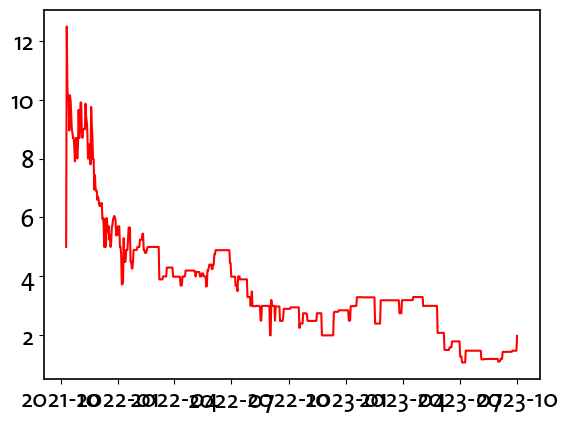

In [46]:
target_tokens_dir = nft_dir + "Target_tokens/"

for file in os.listdir(target_tokens_dir):
    df = pd.read_csv(target_tokens_dir + file)
    df.Date = pd.to_datetime(df.Date)
    
    plt.plot(df.Date, df.price, color = "red")
    plt.plot(df.Date, df.coll_mean)

    break